In [1]:
import torch
import torchvision
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
train_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
	transform=torchvision.transforms.ToTensor()
)

train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [3]:
train_data.classes, len(train_data.classes)

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

In [4]:
train_dl = torch.utils.data.DataLoader(
    train_data,
	batch_size=32,
	shuffle=True
)

test_dl = torch.utils.data.DataLoader(
    test_data,
    batch_size=32
)

len(train_dl), len(test_dl)

(1875, 313)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

---
#### **Model 0:**

In [6]:
class FashionMNISTModelV0(torch.nn.Module):
	def __init__(self, input_shape, hidden_units, output_shape):
		super().__init__()
		self.layer_stack = torch.nn.Sequential(
			torch.nn.Flatten(),
			torch.nn.Linear(input_shape, hidden_units),
			torch.nn.ReLU(),
			torch.nn.Linear(hidden_units, output_shape),
			torch.nn.Softmax(dim=1)
		)

	def forward(self, x):
		return self.layer_stack(x)	

In [7]:
# Input Image:
# [channel, height, width]
# [1, 28, 28]

model_0 = FashionMNISTModelV0(
	input_shape=28*28,
	hidden_units=10,
	output_shape=len(train_data.classes)
).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

#### **Model 1:**

In [8]:
class FashionMNISTModelV1(torch.nn.Module):
	def __init__(self, input_shape, hidden_units, output_shape):
		super().__init__()
		# 28x28 input image
		self.block1 = torch.nn.Sequential(
			torch.nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3,
			stride=1,
			padding=1),
			torch.nn.ReLU(),
			torch.nn.MaxPool2d(kernel_size=2)
		)
		# 14x14 input image
		self.block2 = torch.nn.Sequential(
			torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,
			stride=1,
			padding=1),
			torch.nn.ReLU(),
			torch.nn.MaxPool2d(kernel_size=2)
		)
		# 7x7 input image
		self.classifier = torch.nn.Sequential(
			torch.nn.Flatten(),
			torch.nn.Linear(in_features=hidden_units*7*7, out_features=output_shape),
			torch.nn.ReLU(),
			torch.nn.Linear(in_features=output_shape, out_features=output_shape)
		)
		
	def forward(self, x):
		x = self.block1(x)
		x = self.block2(x)
		x = self.classifier(x)
		return x

In [9]:
# Input Image:
# [channel, height, width]
# [1, 28, 28]

model_1 = FashionMNISTModelV1(
	input_shape=1,
	hidden_units=10,
	output_shape=len(train_data.classes)
).to(device)

model_1

FashionMNISTModelV1(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(device)

optimizer_0 = torch.optim.Adam(params=model_0.parameters(), lr=0.01)
optimizer_1 = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

#### **Defining Training and Testing Functions**

In [11]:
def training(model, train_dl, loss_fn, accuracy_fn, optmizer):
	train_loss = []
	train_acc = []

	model.train()
	for X,y in train_dl:
		X, y = X.to(device), y.to(device)
		y_pred = model(X)
		loss = loss_fn(y_pred, y)
		acc = accuracy_fn(y_pred, y)
		optmizer.zero_grad()
		loss.backward()
		optmizer.step()

		train_loss.append(loss.item())
		train_acc.append(acc.item())
		
	return train_loss, train_acc

In [12]:
def testing(model, test_dl, loss_fn, accuracy_fn):
	test_loss = []
	test_acc = []

	model.eval()
	with torch.inference_mode():
		for X,y in test_dl:
			X, y = X.to(device), y.to(device)
			y_pred = model(X)
			loss = loss_fn(y_pred, y)
			acc = accuracy_fn(y_pred, y)

			test_loss.append(loss.item())
			test_acc.append(acc.item())
		
	return test_loss, test_acc

In [13]:
def loop(model, train_dl, test_dl, loss_fn, accuracy_fn, optimizer = None, epochs = 5):
	train_loss = []
	train_acc = []
	test_loss = []
	test_acc = []
	epochs_count = []

	if optimizer is None:
		optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

	start = time.time()
	for epoch in range(epochs):
		train_loss_epoch, train_acc_epoch = training(model, train_dl, loss_fn, accuracy_fn, optimizer)
		test_loss_epoch, test_acc_epoch  = testing(model, test_dl, loss_fn, accuracy_fn)

		train_loss.append(sum(train_loss_epoch)/len(train_loss_epoch))
		train_acc.append( sum(train_acc_epoch) /len(train_acc_epoch ))
		test_loss.append( sum(test_loss_epoch) /len(test_loss_epoch ))
		test_acc.append(  sum(test_acc_epoch)  /len(test_acc_epoch  ))
		epochs_count.append(epoch)

		print(f"Epoch: {epoch+1}/{epochs}")
		print(f"Train Loss: {train_loss[-1]:.4f} | Train Accuracy: {(train_acc[-1] * 100):.2f}%")
		print(f"Test Loss: {test_loss[-1]:.4f} | Test Accuracy: {(test_acc[-1] * 100):.2f}%")
		print("-"*50)
	end = time.time()

	training_time = end - start
	print(f"Training time: {training_time:.3f} seconds")
	
	return train_loss, train_acc, test_loss, test_acc, training_time

#### **A helper function to plot the model results**

In [14]:
def plot_results(train_loss, train_acc, test_loss, test_acc, epochs_count):
	# Plotting
	plt.figure(figsize=(12, 8))
	plt.subplot(2, 2, 1)
	plt.plot(epochs_count, train_loss, label='Train Loss')
	plt.plot(epochs_count, test_loss, label='Test Loss')
	plt.title('Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()

	plt.subplot(2, 2, 2)
	plt.plot(epochs_count, train_acc, label='Train Accuracy')
	plt.plot(epochs_count, test_acc, label='Test Accuracy')
	plt.title('Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.legend()

	plt.show()

#### **Start the actual training/testing process**

In [15]:
epochs = 3

##### Model 0:

In [16]:
#-- Train model_0
train_loss_0, train_acc_0, test_loss_0, test_acc_0, training_time_0 = loop(
	model=model_0,
	train_dl=train_dl,
	test_dl=test_dl,
	loss_fn=loss_fn,
	accuracy_fn=accuracy_fn,
	optimizer=optimizer_0,
	epochs=epochs
)

Epoch: 1/3
Train Loss: 1.7936 | Train Accuracy: 66.91%
Test Loss: 1.7590 | Test Accuracy: 70.14%
--------------------------------------------------
Epoch: 2/3
Train Loss: 1.7366 | Train Accuracy: 72.42%
Test Loss: 1.7539 | Test Accuracy: 70.62%
--------------------------------------------------
Epoch: 3/3
Train Loss: 1.7326 | Train Accuracy: 72.80%
Test Loss: 1.7603 | Test Accuracy: 69.98%
--------------------------------------------------
Training time: 34.846 seconds


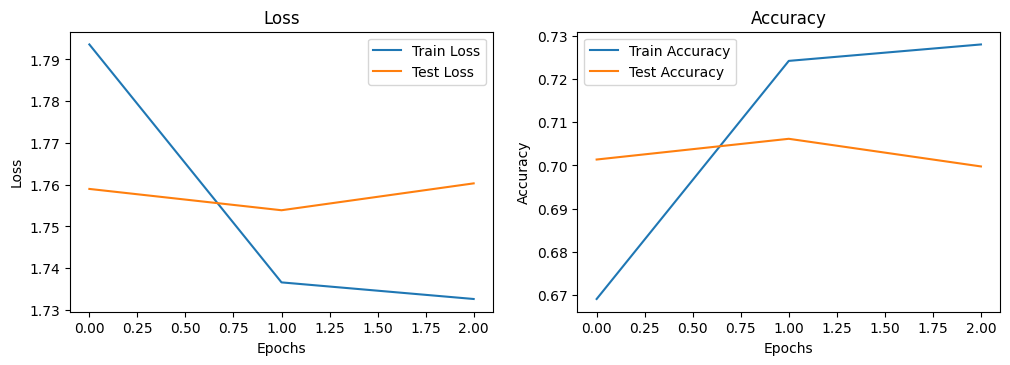

In [17]:
plot_results(train_loss_0, train_acc_0, test_loss_0, test_acc_0, range(epochs))

##### Model 1:

In [18]:
#-- Train model_1
train_loss_1, train_acc_1, test_loss_1, test_acc_1, training_time_1 = loop(
	model=model_1,
	train_dl=train_dl,
	test_dl=test_dl,
	loss_fn=loss_fn,
	accuracy_fn=accuracy_fn,
	optimizer=optimizer_1,
	epochs=epochs
)

Epoch: 1/3
Train Loss: 0.5060 | Train Accuracy: 80.84%
Test Loss: 0.4130 | Test Accuracy: 85.13%
--------------------------------------------------
Epoch: 2/3
Train Loss: 0.3637 | Train Accuracy: 86.62%
Test Loss: 0.3574 | Test Accuracy: 87.51%
--------------------------------------------------
Epoch: 3/3
Train Loss: 0.3437 | Train Accuracy: 87.45%
Test Loss: 0.3509 | Test Accuracy: 87.73%
--------------------------------------------------
Training time: 40.518 seconds


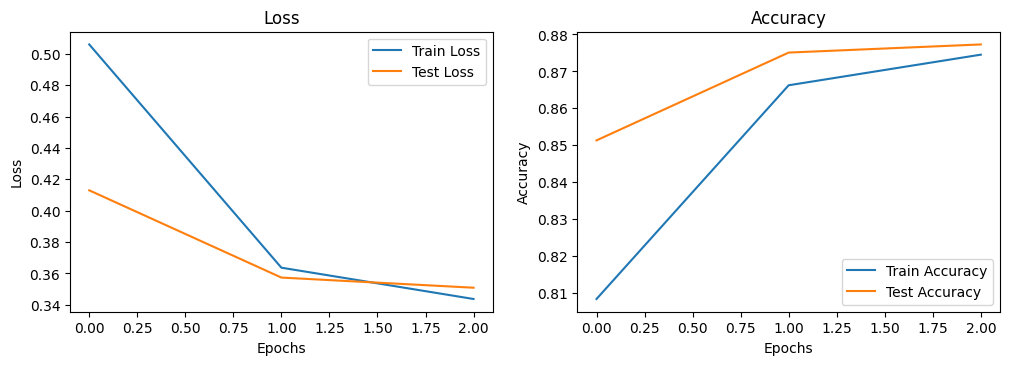

In [19]:
plot_results(train_loss_1, train_acc_1, test_loss_1, test_acc_1, range(epochs))

---
### **Comparing the two model results**

In [20]:
def evaluate_model(model, data_loader, loss_fn, accuracy_fn):
	losses = []
	accuracies = []
	
	model.eval()
	with torch.inference_mode():
		for X, y in data_loader:
			X, y = X.to(device), y.to(device)
			y_pred = model(X)
			loss = loss_fn(y_pred, y)
			acc = accuracy_fn(y_pred, y)

			losses.append(loss.item())
			accuracies.append(acc.item())

	return {
		"model": model.__class__.__name__,
		"loss": sum(losses) / len(losses),
		"accuracy": sum(accuracies) / len(accuracies),
		"num_params": sum(p.numel() for p in model.parameters()),
		"num_classes": len(train_data.classes)
	}

In [21]:
model_0_results = evaluate_model(
	model_0,
	test_dl,
	loss_fn,
	accuracy_fn
)

model_0_results

{'model': 'FashionMNISTModelV0',
 'loss': 1.7603250650552134,
 'accuracy': 0.6997803514376997,
 'num_params': 7960,
 'num_classes': 10}

In [22]:
model_1_results = evaluate_model(
	model_1,
	test_dl,
	loss_fn,
	accuracy_fn
)

model_1_results

{'model': 'FashionMNISTModelV1',
 'loss': 0.35090855751841216,
 'accuracy': 0.8772963258785943,
 'num_params': 6030,
 'num_classes': 10}

In [23]:
compare_results = pd.DataFrame([model_0_results, model_1_results])
compare_results["training_time"] = [training_time_0, training_time_1]
compare_results

,model,loss,accuracy,num_params,num_classes,training_time
0,FashionMNISTModelV0,1.760325,0.699780,7960,10,34.846372
1,FashionMNISTModelV1,0.350909,0.877296,6030,10,40.518076


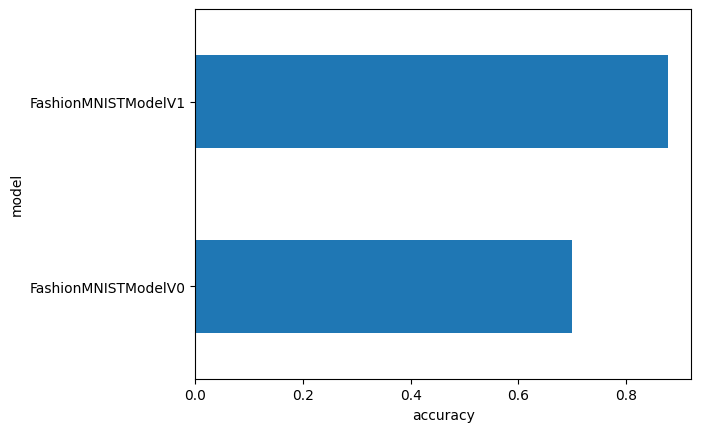

In [24]:
compare_results.set_index("model")["accuracy"].plot(kind="barh")
plt.xlabel("accuracy")
plt.ylabel("model");

---
### **Make Some Predictions**

In [25]:
def make_predictions(model, data, device):
    pred_probs = []
    
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [26]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [27]:
test_labels = torch.tensor(test_labels)
test_labels

tensor([9, 9, 6, 0, 7, 9, 6, 3, 3])

In [28]:
# Make predictions on test samples with model_1
pred_probs= make_predictions(model=model_1, data=test_samples, device=device)
pred_labels = pred_probs.argmax(dim=1)
pred_labels

tensor([9, 9, 6, 0, 7, 9, 6, 3, 0])

In [29]:
test_labels == pred_labels

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False])

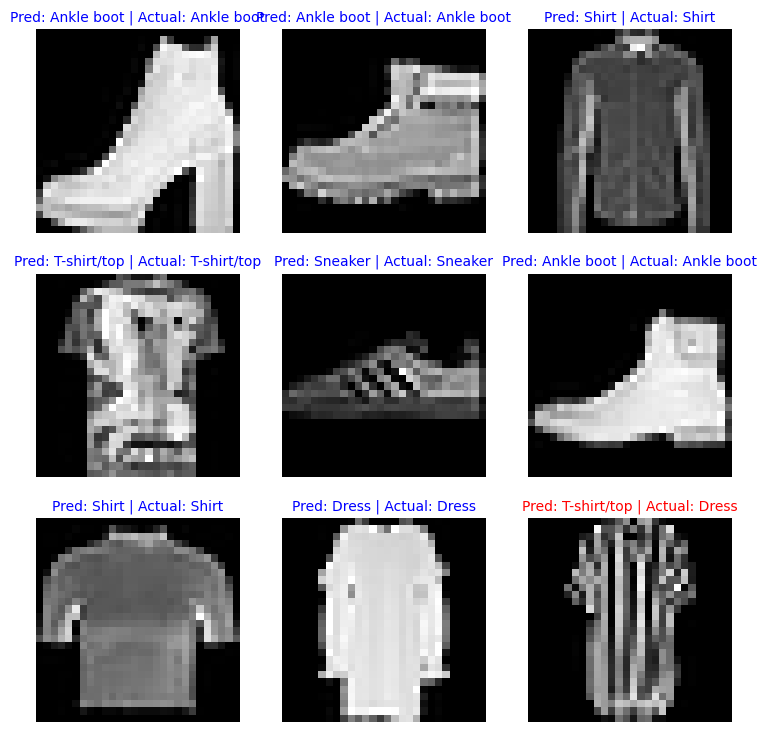

In [30]:
# Plot predictions
plt.figure(figsize=(9, 9))

nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
	plt.subplot(nrows, ncols, i+1)
	plt.imshow(sample.squeeze(), cmap="gray")

	pred_label   = train_data.classes[pred_labels[i]]
	actual_label = train_data.classes[test_labels[i]] 

	title_text = f"Pred: {pred_label} | Actual: {actual_label}"

	if pred_label == actual_label:
		plt.title(title_text, fontsize=10, c="b")
	else:
		plt.title(title_text, fontsize=10, c="r")
	
	plt.axis(False);

---
### **Confusion Matrix**

In [31]:
# Make predictions with trained model
from tqdm import tqdm

y_preds = []

model_1.eval()
with torch.inference_mode():
	for X, y in tqdm(test_dl, desc="Making predictions"):
		# Send data and targets to target device
		X, y = X.to(device), y.to(device)

		# Do the forward pass
		y_logit = model_1(X)

		# Turn predictions from logits -> prediction probabilities -> predictions labels
		y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
		
		# Put predictions on CPU for evaluation
		y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 287.28it/s]


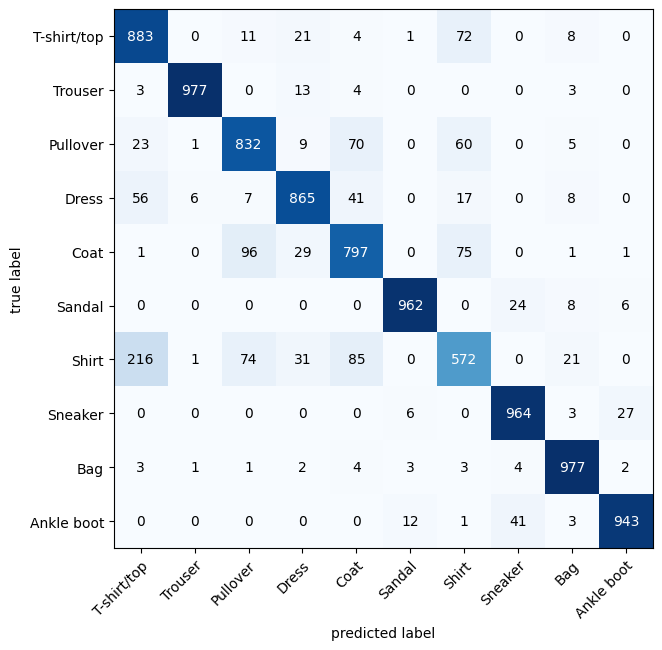

In [32]:
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=len(train_data.classes))
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# Plot the confusion matrix
# An ideal model will have only values in these squares and 0 everywhere else.
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=train_data.classes,
    figsize=(10, 7)
);

---
### **Save the model**

In [33]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict (the learned parameters)
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\model_1.pth
